---
title: Homework 6
author: Jichao Yang
format: 
    pdf:
        documentclass: article
        papersize: letter
        geometry:
            - top = 1in
            - bottom = 1in
            - left = 1in
            - right = 1in
---

# Problem 1

(a) The dataset is prepared by dropping entries with empy data, normalizing the `age` variable, encoding the `passengerClass` variable with dummies, and adding an interept constant column.

In [1]:
import pandas as pd

# Read the dataset
df = pd.read_csv('../../data/TitanicSurvival.csv', index_col='rownames')
df = df.reset_index(drop=True)
df = df.dropna()

# Encode categorical variables
df['survived'] = df['survived'] == 'yes'
df['is_male'] = df['sex'] == 'male'
df['passengerClass'] = df['passengerClass'].str[0]
df = df.rename(columns={'passengerClass': 'class'})
df = df.drop(columns='sex')

# Normalize quantitative variable
df = df.astype('float')
df['is_male'] = (df['is_male'] - df['is_male'].mean())/df['is_male'].std()
df['class'] = (df['class'] - df['class'].mean())/df['class'].std()
df['age'] = (df['age'] - df['age'].mean())/df['age'].std()

# Check the normalization result
df.describe().round(3)

,survived,age,class,is_male
count,1046.000,1046.000,1046.000,1046.000
mean,0.408,0.000,-0.000,0.000
std,0.492,1.000,1.000,1.000
min,0.000,-2.062,-1.435,-1.302
25%,0.000,-0.616,-1.435,-1.302
50%,0.000,-0.131,-0.247,0.768
75%,1.000,0.633,0.942,0.768
max,1.000,3.477,0.942,0.768


\pagebreak
(b) Recall that the 29 year old female passenger in first class can be found in `df.iloc[0]`. The implementation can be found as follow:

In [2]:
import torch
import numpy as np
torch.manual_seed(0)


# Initialize pytorch tensors
variables = ['age', 'class', 'is_male']
X = torch.from_numpy(df[variables].values)              # .shape == n*len(variables)
B = torch.rand(len(variables), 1, dtype=torch.float64)  # .shape == len(variables)*1   
Y = torch.from_numpy(df['survived'].values).view(-1,1)  # .shape == n*1
x0= torch.from_numpy(df.loc[[0],variables].values)      # .shape == 1*len(variables)
y0= torch.from_numpy(df.loc[[0],['survived']].values)   # .shape == 1*1
# Mark variable for training
B.requires_grad = True

def forward(X, B):
    '''
    Apply logistic function on linear product of X and B
    '''
    return torch.sigmoid(X @ B)

y_hat = np.round(forward(x0, B).item(), 3)
print('The chances of the passenger surviving is {}'.format(y_hat))

The chances of the passenger surviving is 0.158


\pagebreak
(c) The implementation can be found as follow:

In [3]:
def loss(X, B, Y):
    '''
    Calculate cross entropy loss between Y and Y_hat,
    predicted by X and B through forward()
    '''
    Y_hat = forward(X, B)
    return - torch.sum(Y * torch.log(Y_hat) + (1-Y) * torch.log(1-Y_hat))

# Calculate loss for x0 and random B
l = loss(x0, B, y0)
print('The loss from the single entry is around {}'.format(np.round(l.item(), 3)))

The loss from the single entry is around 1.845


In [4]:
# Calculate gradient of single loss
l.backward()
grad = np.round(B.grad.tolist(), 3)
print('The gradient from the single loss is {}'.format(grad.tolist()))

The gradient from the single loss is [[0.051], [1.208], [1.096]]


\pagebreak
(d) The training plot can be found as follows:

In [5]:
from tqdm import tqdm
from matplotlib import pyplot as plt

def fit(r, epoch, X=X, Y=Y, B=B, verbose=False, random_start=False):
    '''
    Train logistic model with specified learning rate r and epoch
    '''
    if random_start:
        B_prime = torch.rand(len(variables), 1, dtype=torch.float64)
    else:
        # Preserve original random B for re-training
        B_prime = B.clone().detach()
    # Set B_prime as independent variable
    B_prime.requires_grad = True
    
    # Record epoch, loss, and gradient
    epochs = []
    losses = []
    gradients = []  # .shape == epoch*len(variables) for each variable in B

    # Gradient descent
    for e in tqdm(range(epoch), disable=not verbose):
        # Calculate loss
        l = loss(X, B_prime, Y)
        l.backward()

        # Record epoch info
        epochs.append(e)
        losses.append(l.item())
        gradients.append(B_prime.grad.view(-1).tolist())

        # Perform gradient descent
        with torch.no_grad():
            B_prime -= r * B_prime.grad
        
        # Clear gradient for next epoch
        B_prime.grad.zero_()

    # Transpose gradients for easier plotting
    gradients = np.transpose(gradients).tolist()

    return B_prime.detach(), epochs, losses, gradients

# Train the model using as specified
B_hat, epochs, losses, gradients = fit(1e-5, 1000)

\newpage
Since it does not make sense to compare loss against gradient, they will be graphed separately.

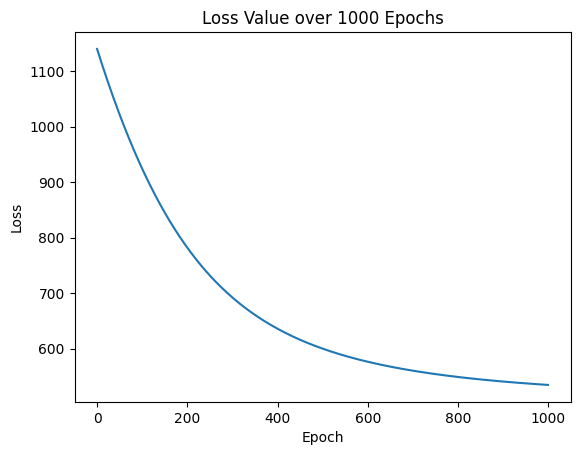

In [6]:
# Graph loss against epoch
plt.plot(losses)
plt.title('Loss Value over 1000 Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

\newpage

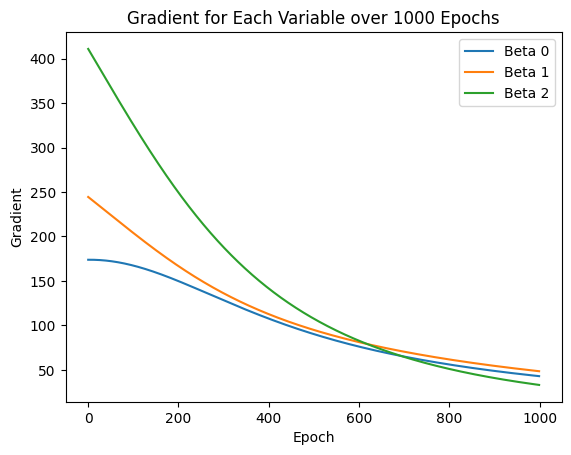

In [7]:
# Graph gradient against epoch
for i in range(3):
    plt.plot(gradients[i], label='Beta {}'.format(i))
plt.title('Gradient for Each Variable over 1000 Epochs')
plt.ylabel('Gradient')
plt.xlabel('Epoch')
plt.legend()
plt.show()

\newpage
(e) After testing, the behavior of the losses are evident after 100 epochs, and the graph is unreadable with epoch set to 1000. Hence for the sake of readability the epoch number will be reduced to 100 for graphing.

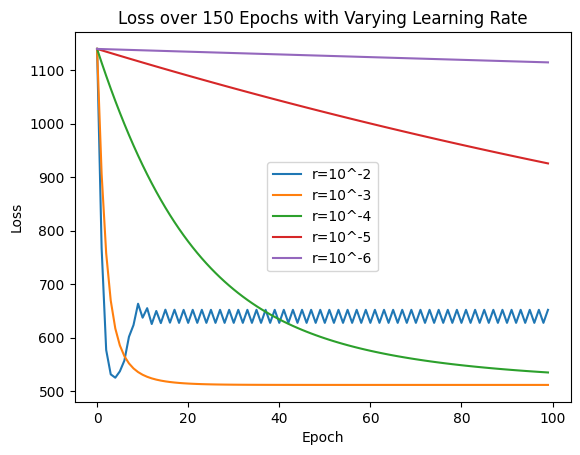

In [8]:
# Record required learning rates
R = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

# Train model on different learning rates
for i, r in enumerate(R):
    _, _, l, _ = fit(r, 100)
    plt.plot(l, label='r=10^{}'.format(int(np.log10(r))))

plt.title('Loss over 150 Epochs with Varying Learning Rate')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


It is evident that $10^{-2}$ is too large of a step for gradient descent for this model. The loss does not converge to a regional minimum. All other learning rates converge well, and the lower the learning rate, the slower that the minimization will eventually converge.

\newpage
(f) To generate a confusion matrix for each model, first we need to convert an output of probability into a prediction. Then we can generate the confusion matrix, and finally plot them for analysis.

In [9]:
from kneed import KneeLocator
import seaborn as sns

class Logistic_Regression:
    X = X
    Y = Y
    epochs = 1000

    def __init__(self, r=1e-5):
        self.r = r
        self.fit()
        self.find_cutoff()
        self.find_confusion_matrix()

    def fit(self):
        self.B, _, _, _ = fit(self.r, Logistic_Regression.epochs)
        self.P_hat = forward(Logistic_Regression.X, self.B)
    
    def find_cutoff(self):
        TP = []
        FP = []
        cutoffs = np.sort(self.P_hat.view(-1).numpy())
        for c in cutoffs:
            tp, fp, tn, fn = self.find_confusion_matrix_(c) # here
            TP.append(tp/(tp+fn))
            FP.append(fp/(fp+tn))
        # ========= This does not work for some reason ========
        # kl = KneeLocator(FP, TP, curve='concave', S=20)
        # self.cutoff = kl.knee
        # self.kl = kl
        # =====================================================
        self.cutoff=0.5     # So we have to do this

    def find_confusion_matrix(self):
        self.TP, self.FP, self.TN, self.FN = self.find_confusion_matrix_(self.cutoff)
    
    def plot_confusion_matrix(self):
        df_cm = pd.DataFrame([[self.TP, self.FP], [self.FN, self.TN]],
                             index = ['Yes', 'No'],
                             columns = ['Predicted Yes', 'Predicted No']
        )
        return sns.heatmap(df_cm, annot=True, cmap='rocket_r', fmt='g')

    def find_confusion_matrix_(self, cutoff):
        Y_hat = (self.P_hat > cutoff).numpy().astype(int)
        Y_true = Logistic_Regression.Y.numpy().astype(int)
        TP = np.logical_and(Y_hat, Y_true).sum()
        FP = np.logical_and(Y_hat, np.logical_not(Y_true)).sum()
        TN = np.logical_and(np.logical_not(Y_hat), np.logical_not(Y_true)).sum()
        FN = np.logical_and(np.logical_not(Y_hat), Y_true).sum()
        return TP, FP, TN, FN

In [11]:
# Generate and train each logistic model
R = [1e-2, 1e-4, 1e-6]
LR = [Logistic_Regression(r=r) for r in R]

# Plot corresponding Confusion Matrix
f, axes = plt.subplots(3, 1)
f.set_size_inches(5, 10)
for i, lr in enumerate(LR):
    df_cm = pd.DataFrame([[lr.TP, lr.FP], [lr.FN, lr.TN]],
                         index=['Yes', 'No'],
                         columns=['Predicted Yes', 'Predicted No']
    )
    sns.heatmap(df_cm, annot=True, cmap='rocket_r', fmt='g', ax=axes[i])
    axes[i].set_title('Confusion Matrix with Learning Rate 10^{}'.format(-i*2-2))
plt.savefig('1(f).png')
plt.close(f)

As we can see from the resulting graph, a too large learning rate causes inability to converge, hence the model has reasonable TP but high FP and FN counts. A too small learning rate causes the model to exit training before converging, resulting in an especially large FN rate and small TP and TN count. An appropriate training rate allows the model to have high TP and TN counts while minimizing FP and FN counts.

![1 (f)](1(f).png)